In [ ]:
!apt-get install -y build-essential python-dev python-numpy python3-dev python3-numpy libjpeg-dev zlib1g-dev libpng-dev


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz


In [ ]:
%cd ta-lib
!./configure --prefix=/usr
!make
!make install


In [ ]:
!pip install Ta-Lib


In [ ]:
!pip install mpl-finance


Since the below code is only fetching data from an API and performing some calculations on it, there is no need for any preprocessing steps like missing value replacement, standardization, or normalization. However, it's always a good practice to check for missing values and outliers in the data, and handle them appropriately before performing any analysis. And

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, YearLocator,MONDAY
from mpl_finance import candlestick_ohlc

# define function to get daily stock data from Alpha Vantage API
def get_daily_data(symbol):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=compact&apikey=H29FNTNOFNL5L7A3"
    response = requests.get(url)
    data = response.json()
    daily_data = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index').astype(float)
    daily_data.index = pd.to_datetime(daily_data.index)
    # handle missing values
    daily_data = daily_data.fillna(method='ffill')
    return daily_data

# define function to check for uptrend
def check_uptrend(stock_data):
    slow_ma = stock_data['4. close'].rolling(window=20).mean()
    fast_ma = stock_data['4. close'].rolling(window=10).mean()
    if fast_ma[-1] > slow_ma[-1] and stock_data['4. close'][-1] > fast_ma[-1]:
        print("Satisfies the uptrend")
        return True
    else:
        print("Does not satisfy the uptrend")
        return False

# define function to check for inside days
def check_inside_days(stock_data):
    # check if previous day's range is inside today's range
    prev_range = stock_data.iloc[-2]['2. high'] - stock_data.iloc[-2]['3. low']
    curr_range = stock_data.iloc[-1]['2. high'] - stock_data.iloc[-1]['3. low']
    if curr_range < prev_range:
        print("Satisfies the inside days")
        return True
    else:
        print("Does not satisfy the inside days")
        return False

# define function to check for volatility contraction
def check_volatility_contraction(stock_data):
    avg_volume = stock_data['6. volume'][-25:].mean()
    curr_volume = stock_data['6. volume'][-1]
    if curr_volume < avg_volume:
        print("Satisfies the VC")
        return True
    else:
        print("Does not satisfy the VC")
        return False


# define function to check if a stock meets all 3 criteria
def check_potential_stock(symbol):
    stock_data = get_daily_data(symbol)

    # check for missing values
    if stock_data.isnull().values.any():
        print("Data contains missing values")
        return False


    if check_uptrend(stock_data) and check_inside_days(stock_data) and check_volatility_contraction(stock_data):
        return True
    else:
        return False


# example usage for stock symbol MSFT
if check_potential_stock('IBM'):
    print("MSFT is a potential stock to buy")
else:
    print("MSFT does not meet all criteria")


Does not satisfy the uptrend
MSFT does not meet all criteria


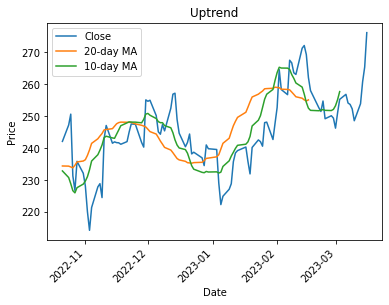

In [ ]:
# plot chart for uptrend
stock_data = get_daily_data('MSFT')
slow_ma = stock_data['4. close'].rolling(window=20).mean()
fast_ma = stock_data['4. close'].rolling(window=10).mean()
plt.plot(stock_data.index, stock_data['4. close'], label='Close')
plt.plot(slow_ma.index, slow_ma, label='20-day MA')
plt.plot(fast_ma.index, fast_ma, label='10-day MA')
plt.legend()
plt.title('Uptrend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
def plot_inside_days(symbol):
    stock_data = get_daily_data(symbol)
    if not check_inside_days(stock_data):
        print(f"{symbol} does not have inside days")
        return
    stock_data = stock_data.reset_index()
    yearLocator = YearLocator()        # major ticks on the months
    yearFormatter = DateFormatter('%b %Y')  # e.g., Jan 2022
    quotes = [tuple([i]+list(stock_data.loc[i, ['1. open', '2. high', '3. low', '4. close']])) for i in range(len(stock_data))]
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(yearLocator)
    ax.xaxis.set_major_formatter(yearFormatter)
    candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r')
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title('Inside Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

plot_inside_days('MSFT')


Does not satisfy the inside days
MSFT does not have inside days


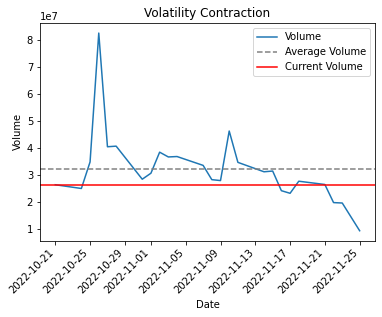

In [ ]:
stock_data = get_daily_data('MSFT')
avg_volume = stock_data['6. volume'][-25:].mean()
curr_volume = stock_data['6. volume'][-1]

plt.plot(stock_data.index[-25:], stock_data['6. volume'][-25:], label='Volume')
plt.axhline(y=avg_volume, linestyle='--', color='gray', label='Average Volume')
plt.axhline(y=curr_volume, linestyle='-', color='red', label='Current Volume')

plt.legend()
plt.title('Volatility Contraction')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
from math import sqrt
import pandas as pd
import requests
import talib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Define the API endpoint and parameters
url = "https://www.alphavantage.co/query"
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "GOOG",
    "outputsize": "compact",
    "apikey": "H29FNTNOFNL5L7A3"
}

# Send the API request and parse the response
response = requests.get(url, params=params)
data = response.json()["Time Series (Daily)"]

# Convert the data to a Pandas DataFrame
df = pd.DataFrame.from_dict(data, orient="index")
df = df.astype(float)

# Add additional features
df["SMA10"] = df["4. close"].rolling(window=10).mean()
df["EMA10"] = df["4. close"].ewm(span=10, adjust=False).mean()
df["RSI14"] = talib.RSI(df["4. close"].values, timeperiod=14)
df["ADX"] = talib.ADX(df["2. high"].values, df["3. low"].values, df["4. close"].values, timeperiod=14)

# Drop rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[["1. open", "6. volume", "SMA10", "EMA10", "RSI14", "ADX"]]
y = df["4. close"]

# Split the data into training and testing sets using time series split
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features using the StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the multiple linear regression model
    regressor = LinearRegression()
    regressor.fit(X_train_scaled, y_train)
    y_pred_lr = regressor.predict(X_test_scaled)

    # Count the number of days when the stock price increased and the number of days when the model predicted an increase
    actual_increase = 0
    predicted_increase = 0
    for i in range(len(y_test) - 1):
        actual_diff = y_test[i + 1] - y_test[i]
        predicted_diff = y_pred_lr[i + 1] - y_pred_lr[i]
        if actual_diff > 0:
            actual_increase += 1
        if predicted_diff > 0:
            predicted_increase += 1
    print("Multiple Linear Regression:")
    print("Days when actual stock price increased:", actual_increase)
    print("Days when model predicted stock price increase:", predicted_increase)

    # Fit the decision tree regression model
    tree_regressor = DecisionTreeRegressor(random_state=42)
    tree_regressor.fit(X_train, y_train)
    y_pred_dt = tree_regressor.predict(X_test)

    # Count the number of days when the stock price increased and the number of days when the model predicted an increase
    actual_increase = 0
    predicted_increase = 0
    for i in range(len(y_test) - 1):
        actual_diff = y_test[i + 1] - y_test[i]
        predicted_diff = y_pred_dt[i + 1] - y_pred_dt[i]
        if actual_diff > 0:
            actual_increase += 1
        if predicted_diff > 0:
            predicted_increase += 1
    print("Decision Tree Regression:")
    print("Days when actual stock price increased:", actual_increase)
    print("Days when model predicted stock price increase:", predicted_increase)

    # Fit the support vector regression model
    svr_regressor = SVR(kernel="rbf")
    svr_regressor.fit(X_train_scaled, y_train)
    y_pred_sr = svr_regressor.predict(X_test_scaled)

    # Count the number of days when the stock price increased and the number of days when the model predicted an increase
    actual_increase = 0
    predicted_increase = 0
    for i in range(len(y_test) - 1):
        actual_diff = y_test[i + 1] - y_test[i]
        predicted_diff = y_pred_sr[i + 1] - y_pred_sr[i]
        if actual_diff > 0:
            actual_increase += 1
        if predicted_diff > 0:
            predicted_increase += 1
    print("Support Vector Regression:")
    print("Days when actual stock price increased:", actual_increase)
    print("Days when model predicted stock price increase:", predicted_increase)

    # Print the root mean squared error for each model
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    mse_svr = mean_squared_error(y_test, y_pred_sr)
    print("Multiple Linear Regression RMSE:", mse_lr)
    print("Decision Tree Regression RMSE:", mse_dt)
    print("Support Vector Regression RMSE:", mse_svr)

Multiple Linear Regression:
Days when actual stock price increased: 16
Days when model predicted stock price increase: 16
Decision Tree Regression:
Days when actual stock price increased: 16
Days when model predicted stock price increase: 7
Support Vector Regression:
Days when actual stock price increased: 16
Days when model predicted stock price increase: 15
Multiple Linear Regression RMSE: 15.194741776304568
Decision Tree Regression RMSE: 31.914154166666673
Support Vector Regression RMSE: 5.5161630950108895
Multiple Linear Regression:
Days when actual stock price increased: 11
Days when model predicted stock price increase: 12
Decision Tree Regression:
Days when actual stock price increased: 11
Days when model predicted stock price increase: 7
Support Vector Regression:
Days when actual stock price increased: 11
Days when model predicted stock price increase: 12
Multiple Linear Regression RMSE: 3.570700696106225
Decision Tree Regression RMSE: 4.79449999999999
Support Vector Regressio